# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
os.chdir('..')
messages = pd.read_csv('data/orders_data_btc_usd_coinbase.csv')

# Features

To train the model, one needs a list of events and the market features previous to those events, up to an horizon corresponding to the CNN's horizons.
The market features are:
- spread, midprice
- time indicators (cos and sin)
- volatility
- imbalance
- microprice
- prices and volumes at the 5 best levels

## Exploring our data

In [3]:
# timestamps insertion
ts = messages['timestamp_insertion']
dt = ts.diff()
print(dt.describe())

count    485373.000000
mean          0.005116
std           0.608625
min        -292.179579
25%           0.000074
50%           0.000415
75%           0.004817
max         292.184065
Name: timestamp_insertion, dtype: float64


In [4]:
# create a test dataset
test_dataset = messages[(messages["side"] == "B") & (messages["distance_from_bbo_insertion"] == 0)]
test_dataset = test_dataset[['price',
       'is_modified', 'distance_from_bbo_insertion',
       'ba_spread_insertion', 'bbo_imbalance',
       'limit_order_flow_imbalance', 'roll_hf_volatility_insertion',
       'cause','lifetime']]

## First prototype with LOBSTER data

In [10]:
# with LOBSTER data
lob_messages = pd.read_csv('data/LOBSTER/AMZN_2012-06-21_34200000_57600000_message_5.csv', header=None)
lob_messages.columns = ['time', 'type', 'order_id', 'size', 'price', 'direction']
lob_snaps = pd.read_csv('data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_5.csv', header=None)

In [25]:
# select randomly 200 orders and compute KM estimator
random_sample_id = lob_messages[lob_messages['type'] == 1].sample(200)['order_id']
random_sample = lob_messages[lob_messages['order_id'].isin(random_sample_id)]
max_t = random_sample['time'].max() # beware, 7 indicates the trade halt

# computing lifetimes
durations = {}
for order_id, group in random_sample.groupby('order_id'):
    if len(group) == 1:
        duration = max_t - group['time'].values[0]
    else:
        duration = group['time'].values[1] - group['time'].values[0]
    durations[order_id] = duration
random_sample['lifetime'] = random_sample['order_id'].map(durations)

C:\Users\Paul\AppData\Local\Temp\ipykernel_11040\1390211062.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_sample['lifetime'] = random_sample['order_id'].map(durations)


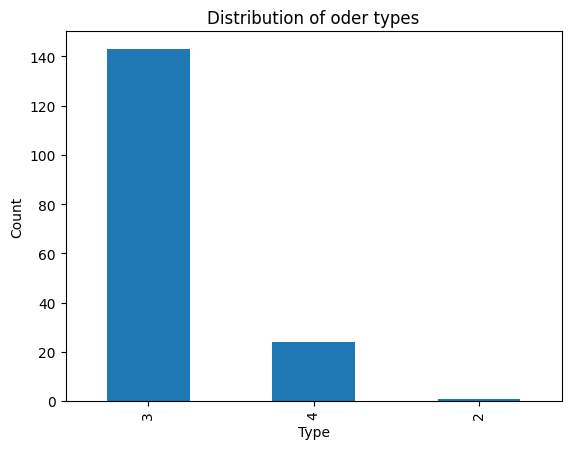

Text(0.5, 1.0, 'Kaplan-Meier estimator')

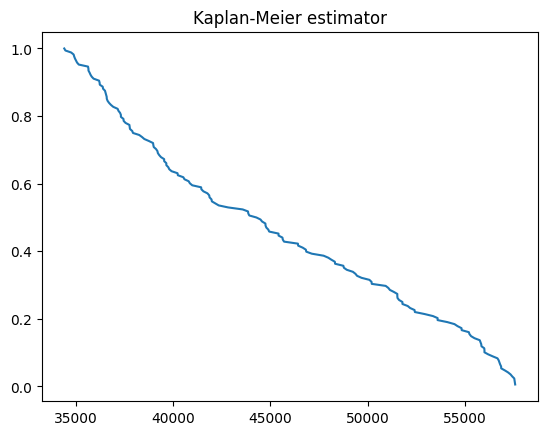

In [43]:
# dataset
random_sample = random_sample.groupby('order_id').nth(1).reset_index()
dataset["type"].value_counts().plot(kind="bar")
plt.title("Distribution of oder types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

# compute the KM estimator
dataset = dataset.sort_values(by=['time'])
dataset['km'] = 1 - np.arange(len(dataset))/len(dataset)
plt.plot(dataset['time'], dataset['km'])
plt.title('Kaplan-Meier estimator')

# Generate not-so-random data with the right format train a model